In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleanedv2/cleaned_train_v2.csv
/kaggle/input/cleanedv2/cleaned_test_v2.csv


In [2]:
train = pd.read_csv('/kaggle/input/cleanedv2/cleaned_train_v2.csv')
test = pd.read_csv('/kaggle/input/cleanedv2/cleaned_test_v2.csv')

In [3]:
test.isnull().sum()

Unnamed: 0        0
review_id         0
review_text       0
emoji_to_text     0
no_punctuation    0
lowered           0
no_number         0
no_stopwords      0
stemmed           0
dtype: int64

In [4]:
train.isnull().sum()

Unnamed: 0         0
review_id          0
review_text        0
category           0
emoji_to_text      0
no_punctuation     8
lowered            8
no_number          8
no_stopwords      12
stemmed           15
dtype: int64

In [5]:
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)


# Coba bikin model

In [6]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

In [7]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=1000, shuffle=True)
positive = train['category'] == 1

In [8]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Target Rate (positive) {}/{} (negative)'.format(train[positive]['category'].count(), train[~positive]['category'].count()))


for fold, (trn_idx, val_idx) in enumerate(skf.split(train['stemmed'], train['category']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train.loc[trn_idx, 'stemmed'].shape, train.loc[val_idx, 'stemmed'].shape))

Training Set Shape = (14841, 10)
Training Set Target Rate (positive) 2016/12825 (negative)

Fold 1 Training Set Shape = (7420,) - Validation Set Shape = (7421,)

Fold 2 Training Set Shape = (7421,) - Validation Set Shape = (7420,)


In [9]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [10]:
import tokenization

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [11]:
class ClassificationReport(Callback):

    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

In [12]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 11.2 s, sys: 2.76 s, total: 14 s
Wall time: 16.5 s


In [13]:
class TextClassifier:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['stemmed'], X['category'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 'stemmed'].str.lower())
            y_trn = X.loc[trn_idx, 'category']
            X_val_encoded = self.encode(X.loc[val_idx, 'stemmed'].str.lower())
            y_val = X.loc[val_idx, 'category']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=text_classifier.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=text_classifier.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=text_classifier.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=text_classifier.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=text_classifier.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=text_classifier.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['stemmed'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

In [14]:
text_classifier = TextClassifier(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

text_classifier.train(train)


Fold 0

Epoch 1/10
232/232 [==============================] - 155s 599ms/step - loss: 0.4241 - accuracy: 0.8470 - val_loss: 0.3638 - val_accuracy: 0.8639

Epoch: 1 - Training Precision: 0.432048 - Training Recall: 0.499766 - Training F1: 0.463446
Epoch: 1 - Validation Precision: 0.557115 - Validation Recall: 0.500262 - Validation F1: 0.464473
Epoch 2/10
232/232 [==============================] - 137s 591ms/step - loss: 0.3399 - accuracy: 0.8718 - val_loss: 0.3297 - val_accuracy: 0.8650

Epoch: 2 - Training Precision: 0.822529 - Training Recall: 0.513265 - Training F1: 0.491012
Epoch: 2 - Validation Precision: 0.716032 - Validation Recall: 0.511337 - Validation F1: 0.488332
Epoch 3/10
232/232 [==============================] - 137s 591ms/step - loss: 0.3233 - accuracy: 0.8660 - val_loss: 0.2943 - val_accuracy: 0.8844

Epoch: 3 - Training Precision: 0.848402 - Training Recall: 0.607396 - Training F1: 0.643946
Epoch: 3 - Validation Precision: 0.824059 - Validation Recall: 0.603669 - Vali

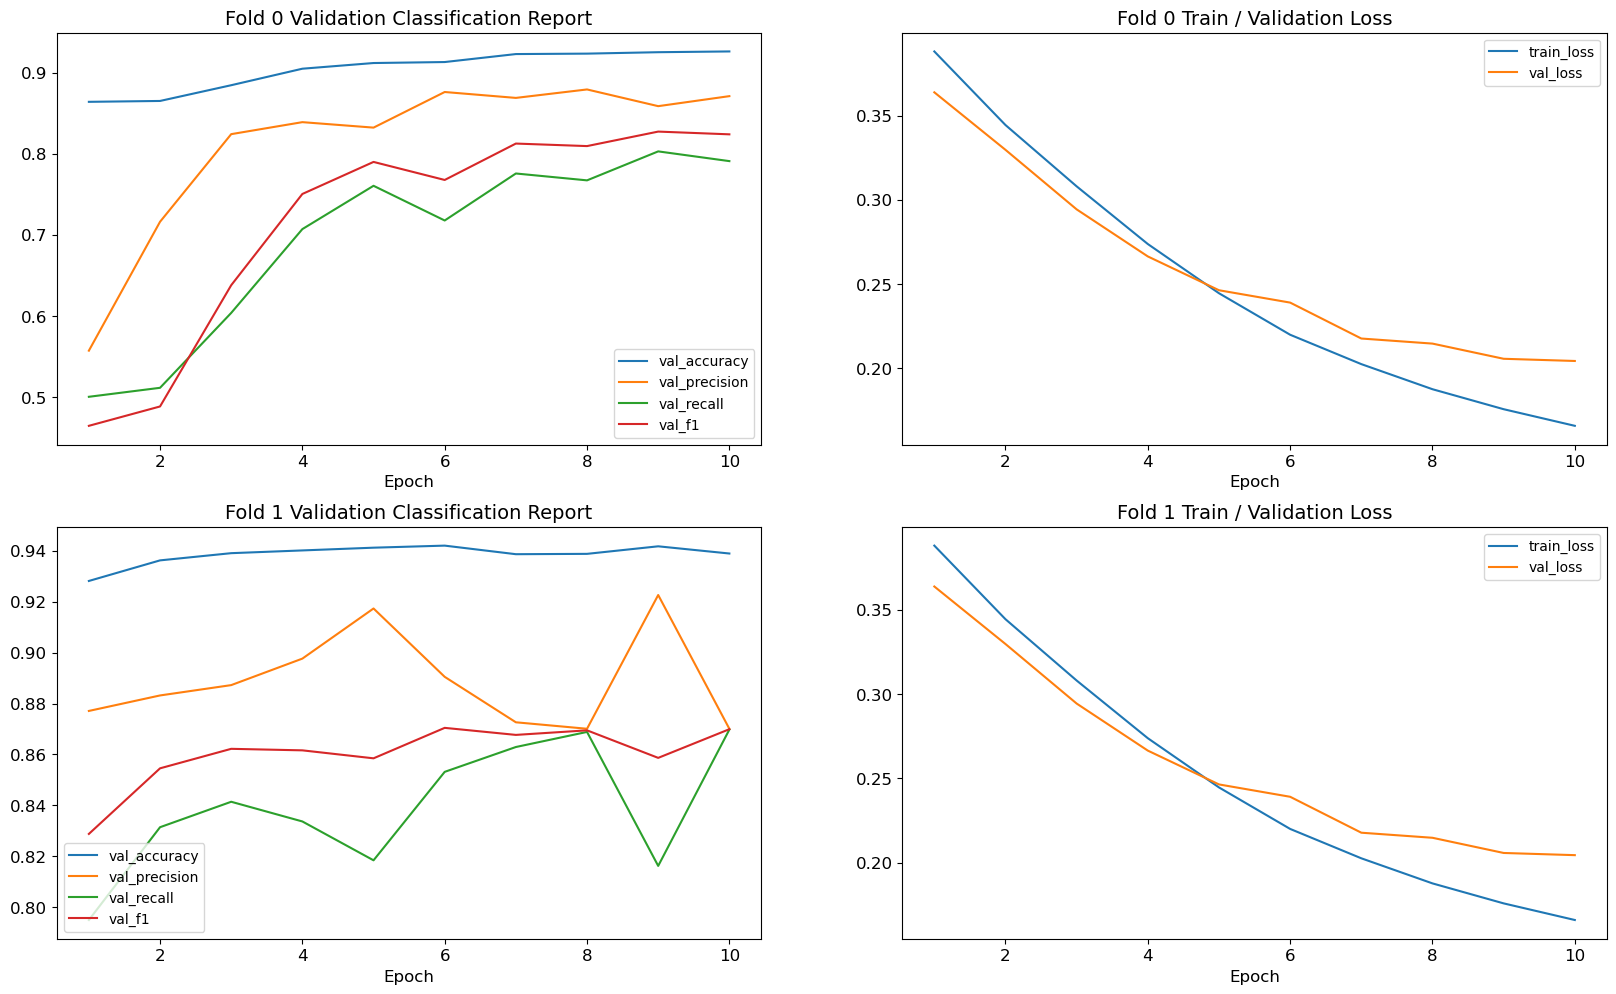

In [15]:
text_classifier.plot_learning_curve()

In [16]:
import numpy as np
y_pred = np.round(text_classifier.predict(test))

In [17]:
submission = pd.DataFrame(np.c_[test.review_id, y_pred.astype('int')], columns = ['review_id', 'category'])

In [18]:
submission

,review_id,category
0,7302180ac7160f04a405d8aa7bd6beb8,0
1,3184c670e170f565c7522eb76a320ba1,0
2,e33abf6bb5d5a9a77c339043b1725dc8,0
3,061d388950340070a6ac03fabc9027b0,0
4,e62d87c348674b6c06856964f3ab16b8,1
...,...,...
3709,4fac4c272d9194021f921138ebd5b389,0
3710,4fabd4722dd4074841f9656f75105f09,0
3711,44ff89997547d54cccb2a33776181240,0
3712,c46cf84e3665a10199a539fee919edd6,0


In [19]:
submission.to_csv('submission_bert_v1,1.csv', index = False)